# Model Engine: Training & Strategy Formulation

This notebook builds the core ML models for trading signal generation:
1. **Installation** - Set up required libraries
2. **Imports** - Load all dependencies
3. **Data Loading** - Load preprocessed data from Part 1
4. **Feature Engineering** - Create 42 features (32 base + 10 interactions)
5. **Data Splitting** - Proper 60/20/20 train/validation/test chronological split
6. **Classification Model** - Multi-horizon ensemble (5d/10d/20d) for buy signals
7. **Regression Model** - Predict return magnitude for position sizing
8. **Export** - Save predictions for backtesting

The approach prioritizes anti-overfitting through honest validation methodology.

In [1]:
import sys
!"{sys.executable}" -m pip install -q --upgrade "imbalanced-learn>=0.13" "catboost>=1.2.5"
print("✅ Packages installed/updated for current kernel")

✅ Packages installed/updated for current kernel


## 1. Setup Dependencies

Install required ML packages for model training (CatBoost, enhanced XGBoost/LightGBM).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported (XGBoost + LightGBM upgrade)")

✅ All libraries imported (XGBoost + LightGBM upgrade)


## 2. Import Libraries

Load all necessary libraries for data processing, model training, and evaluation.

In [3]:
df = pd.read_csv('processed_data.csv', parse_dates=['Date'])
df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

print(f"📄 Data loaded successfully")
print(f"Shape: {df.shape}", f"Date range: {df['Date'].min()} to {df['Date'].max()}", f"Unique tickers: {df['Ticker'].nunique()}", sep='\n')

📄 Data loaded successfully
Shape: (245995, 39)
Date range: 2016-04-05 00:00:00 to 2026-01-16 00:00:00
Unique tickers: 100


## 3. Load Data

Load preprocessed data from Part 1 (1_data_cleaning.ipynb) containing 32 engineered features.

In [4]:
base_features = [
    'log_ret', 'volatility_20', 'rsi_14', 'macd', 'ema_12', 'ema_26',
    'volume_ratio', 'volume_sma_20', 'volume_trend', 'volume_roc_5',
    'roc_5', 'roc_10', 'momentum_score', 'momentum_acceleration',
    'log_ret_lag1', 'log_ret_lag2', 'log_ret_lag3', 'ret_mean_5', 'ret_mean_10', 'ret_std_5',
    'atr_14', 'bb_position', 'bb_std', 'bb_middle', 'bb_upper', 'bb_lower', 'vol_regime',
    'sma_50', 'price_to_sma50', 'daily_range',
    'relative_strength',
    'gap'
]

print(f"✅ Using ALL {len(base_features)} base features")

print("🔧 Creating interaction features...")

df['momentum_vol'] = df['momentum_score'] * df['volatility_20']
df['rsi_volume'] = df['rsi_14'] * df['volume_ratio']
df['trend_strength'] = df['macd'] * df['rsi_14']
df['volatility_regime'] = df['volatility_20'] * df['vol_regime']
df['price_momentum'] = df['price_to_sma50'] * df['momentum_score']
df['volume_momentum'] = df['volume_roc_5'] * df['momentum_score']
df['bb_trend'] = df['bb_position'] * df['macd']
df['relative_mom'] = df['relative_strength'] * df['momentum_score']
df['volatility_mean_ret'] = df['volatility_20'] * df['ret_mean_5']
df['gap_volume'] = df['gap'] * df['volume_ratio']

interaction_features = [
    'momentum_vol', 'rsi_volume', 'trend_strength', 'volatility_regime',
    'price_momentum', 'volume_momentum', 'bb_trend', 'relative_mom',
    'volatility_mean_ret', 'gap_volume'
]

print(f"✅ Created {len(interaction_features)} interaction features")

feature_cols = base_features + interaction_features
print(f"🎯 TOTAL FEATURES: {len(feature_cols)}")

missing_features = [col for col in feature_cols if col not in df.columns]
if missing_features:
    print(f"⚠️ Missing features: {missing_features}")
    feature_cols = [f for f in feature_cols if f in df.columns]
else:
    print(f"✅ All {len(feature_cols)} features available")

print("\n🎯 Creating multi-horizon targets...")

df['future_return_5d'] = df.groupby('Ticker')['Close'].shift(-5) / df['Close'] - 1
df['future_return_10d'] = df.groupby('Ticker')['Close'].shift(-10) / df['Close'] - 1
df['future_return_20d'] = df.groupby('Ticker')['Close'].shift(-20) / df['Close'] - 1

df['target_clf_5d'] = (df['future_return_5d'] > 0).astype(int)
df['target_clf_10d'] = (df['future_return_10d'] > 0).astype(int)
df['target_clf_20d'] = (df['future_return_20d'] > 0).astype(int)

df['target_reg_5d'] = df['future_return_5d']
df['target_reg_10d'] = df['future_return_10d']
df['target_reg_20d'] = df['future_return_20d']

print("📊 Creating ranking targets (cross-sectional)...")
df['rank_10d'] = df.groupby('Date')['future_return_10d'].rank(pct=True)

target_cols = [
    'target_clf_5d', 'target_clf_10d', 'target_clf_20d',
    'target_reg_5d', 'target_reg_10d', 'target_reg_20d',
    'rank_10d'
]
df_model = df.dropna(subset=feature_cols + target_cols).copy()

print(f"\n🤖 Enhanced data prepared for modeling:")
print(f"  Total features: {len(feature_cols)} (32 base + 10 interactions)")
print(f"  Training samples: {len(df_model):,}")
print(f"  Multi-horizon targets: 5-day, 10-day, 20-day")
print(f"  Ranking target included: Yes (cross-sectional percentile)")
print(f"\n📈 Class distribution across horizons:")
print(f"  5-day UP: {(df_model['target_clf_5d']==1).sum() / len(df_model):.1%}")
print(f"  10-day UP: {(df_model['target_clf_10d']==1).sum() / len(df_model):.1%}")
print(f"  20-day UP: {(df_model['target_clf_20d']==1).sum() / len(df_model):.1%}")

✅ Using ALL 32 base features
🔧 Creating interaction features...
✅ Created 10 interaction features
🎯 TOTAL FEATURES: 42
✅ All 42 features available

🎯 Creating multi-horizon targets...
📊 Creating ranking targets (cross-sectional)...

🤖 Enhanced data prepared for modeling:
  Total features: 42 (32 base + 10 interactions)
  Training samples: 243,995
  Multi-horizon targets: 5-day, 10-day, 20-day
  Ranking target included: Yes (cross-sectional percentile)

📈 Class distribution across horizons:
  5-day UP: 55.3%
  10-day UP: 57.0%
  20-day UP: 58.9%


## 4. Feature Engineering & Target Creation

Create 42 total features:
- **32 base features**: technical indicators, momentum, volume, lagged returns, Bollinger Bands, etc.
- **10 interaction features**: captures non-linear relationships (momentum×volatility, RSI×volume, etc.)

Create **multi-horizon targets** (5d, 10d, 20d) for both classification (up/down) and regression (magnitude).

In [5]:
unique_dates = sorted(df_model['Date'].unique())
train_idx = int(len(unique_dates) * 0.6)
val_idx = int(len(unique_dates) * 0.8)

train_dates = unique_dates[:train_idx]
val_dates = unique_dates[train_idx:val_idx]
test_dates = unique_dates[val_idx:]

train_df = df_model[df_model['Date'].isin(train_dates)].copy()
val_df = df_model[df_model['Date'].isin(val_dates)].copy()
test_df = df_model[df_model['Date'].isin(test_dates)].copy()

X_train = train_df[feature_cols]
X_val = val_df[feature_cols]
X_test = test_df[feature_cols]

y_train_clf = train_df['target_clf_10d']
y_train_reg = train_df['target_reg_10d']
y_val_clf = val_df['target_clf_10d']
y_val_reg = val_df['target_reg_10d']
y_test_clf = test_df['target_clf_10d']
y_test_reg = test_df['target_reg_10d']

y_train_clf_5d = train_df['target_clf_5d']
y_train_clf_20d = train_df['target_clf_20d']
y_val_clf_5d = val_df['target_clf_5d']
y_val_clf_20d = val_df['target_clf_20d']
y_test_clf_5d = test_df['target_clf_5d']
y_test_clf_20d = test_df['target_clf_20d']

y_train_reg_5d = train_df['target_reg_5d']
y_train_reg_20d = train_df['target_reg_20d']
y_val_reg_5d = val_df['target_reg_5d']
y_val_reg_20d = val_df['target_reg_20d']
y_test_reg_5d = test_df['target_reg_5d']
y_test_reg_20d = test_df['target_reg_20d']

y_train_rank = train_df['rank_10d']
y_val_rank = val_df['rank_10d']
y_test_rank = test_df['rank_10d']

X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_val = X_val.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

train_median = X_train.median()
X_train = X_train.fillna(train_median)
X_val = X_val.fillna(train_median)
X_test = X_test.fillna(train_median)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ HONEST Train/Validation/Test Split (60/20/20 - Time-Based)")
print(f"   Train dates:      {train_df['Date'].min()} to {train_df['Date'].max()} | Samples: {len(X_train):,}")
print(f"   Validation dates: {val_df['Date'].min()} to {val_df['Date'].max()} | Samples: {len(X_val):,}")
print(f"   Test dates:       {test_df['Date'].min()} to {test_df['Date'].max()} | Samples: {len(X_test):,}")
print(f"\n   Features: {len(feature_cols)} (32 base + 10 interactions)")
print(f"   Multi-horizon targets: 5-day, 10-day, 20-day classification & regression")
print(f"   Ranking target: Cross-sectional percentile")
print(f"\n   🎯 Validation set will be used for:")
print(f"      - Threshold optimization")
print(f"      - Horizon weight selection")
print(f"      - Model selection")
print(f"\n   🔒 Test set will NEVER be touched until final evaluation")


✅ HONEST Train/Validation/Test Split (60/20/20 - Time-Based)
   Train dates:      2016-04-05 00:00:00 to 2022-01-26 00:00:00 | Samples: 146,460
   Validation dates: 2022-01-27 00:00:00 to 2024-01-05 00:00:00 | Samples: 48,794
   Test dates:       2024-01-08 00:00:00 to 2025-12-17 00:00:00 | Samples: 48,741

   Features: 42 (32 base + 10 interactions)
   Multi-horizon targets: 5-day, 10-day, 20-day classification & regression
   Ranking target: Cross-sectional percentile

   🎯 Validation set will be used for:
      - Threshold optimization
      - Horizon weight selection
      - Model selection

   🔒 Test set will NEVER be touched until final evaluation


## 5. Anti-Overfitting: Time-Aware Data Split

Implement strict chronological 60/20/20 split to prevent overfitting:
- **Train (60%)**: Used only for model fitting
- **Validation (20%)**: Used for threshold tuning and hyperparameter selection
- **Test (20%)**: Sacred - never touched during development, used only for final honest evaluation

All preprocessing (scaling, imputation) fits on training data only.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import catboost as cb

print("🚀 TIER 1 OPTIMIZED: Multi-Horizon + Enhanced Features + Walk-Forward Validation")
print("="*80)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_clf), y=y_train_clf)
scale_pos_weight = class_weights[1] / class_weights[0]

print(f"\n📊 Training Strategy:")
print(f"  Features: {len(feature_cols)} (32 base + 10 interactions)")
print(f"  Horizons: 5-day, 10-day, 20-day")
print(f"  Class weight ratio: {scale_pos_weight:.2f}")



print(f"\n🔄 Training Multi-Horizon Classification Models...")

horizons = {
    '5d': (y_train_clf_5d, y_val_clf_5d, y_test_clf_5d),
    '10d': (y_train_clf, y_val_clf, y_test_clf),
    '20d': (y_train_clf_20d, y_val_clf_20d, y_test_clf_20d)
}

horizon_models = {}
horizon_predictions_val = {}  
horizon_predictions_test = {}  

for horizon_name, (y_tr, y_va, y_te) in horizons.items():
    print(f"\n  Training {horizon_name} models...")
    
    cw = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
    spw = cw[1] / cw[0]
    
    cb_clf = cb.CatBoostClassifier(
        iterations=500,
        depth=6,
        learning_rate=0.01,
        subsample=0.7,
        colsample_bylevel=0.7,
        scale_pos_weight=spw,
        l2_leaf_reg=5.0,
        random_state=42,
        thread_count=-1,
        verbose=0
    )
    cb_clf.fit(X_train, y_tr)
    
    xgb_clf = xgb.XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.005,
        subsample=0.7,
        colsample_bytree=0.7,
        min_child_weight=10,
        gamma=0.5,
        reg_alpha=1.0,
        reg_lambda=3.0,
        scale_pos_weight=spw,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
    xgb_clf.fit(X_train, y_tr)
    
    lgb_clf = lgb.LGBMClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.005,
        subsample=0.7,
        colsample_bytree=0.7,
        min_child_samples=50,
        reg_alpha=1.0,
        reg_lambda=3.0,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgb_clf.fit(X_train, y_tr)
    
    cb_proba_val = cb_clf.predict_proba(X_val)[:, 1]
    xgb_proba_val = xgb_clf.predict_proba(X_val)[:, 1]
    lgb_proba_val = lgb_clf.predict_proba(X_val)[:, 1]
    
    cb_proba_test = cb_clf.predict_proba(X_test)[:, 1]
    xgb_proba_test = xgb_clf.predict_proba(X_test)[:, 1]
    lgb_proba_test = lgb_clf.predict_proba(X_test)[:, 1]
    
    X_meta_train = np.column_stack([
        cb_clf.predict_proba(X_train)[:, 1],
        xgb_clf.predict_proba(X_train)[:, 1],
        lgb_clf.predict_proba(X_train)[:, 1]
    ])
    
    X_meta_val = np.column_stack([cb_proba_val, xgb_proba_val, lgb_proba_val])
    X_meta_test = np.column_stack([cb_proba_test, xgb_proba_test, lgb_proba_test])
    
    meta_clf = LogisticRegression(max_iter=2000, C=0.05, class_weight='balanced', random_state=42)
    meta_clf.fit(X_meta_train, y_tr)
    
    horizon_proba_val = meta_clf.predict_proba(X_meta_val)[:, 1]
    horizon_proba_test = meta_clf.predict_proba(X_meta_test)[:, 1]
    
    horizon_models[horizon_name] = {
        'cb': cb_clf, 'xgb': xgb_clf, 'lgb': lgb_clf, 'meta': meta_clf
    }
    horizon_predictions_val[horizon_name] = horizon_proba_val
    horizon_predictions_test[horizon_name] = horizon_proba_test
    
    print(f"    ✅ {horizon_name} models trained (CatBoost + XGBoost + LightGBM + Meta)")



print(f"\n🔀 Optimizing multi-horizon fusion weights on VALIDATION set...")

print(f"\n📊 Individual Horizon Probability Distributions (Validation):")
for horizon_name, horizon_proba in horizon_predictions_val.items():
    print(f"   {horizon_name}: Mean={horizon_proba.mean():.3f}, Median={np.median(horizon_proba):.3f}, "
          f"Min={horizon_proba.min():.3f}, Max={horizon_proba.max():.3f}")

from sklearn.metrics import f1_score, precision_score

weight_combinations = [
    {'5d': 0.50, '10d': 0.35, '20d': 0.15},  
    {'5d': 0.33, '10d': 0.34, '20d': 0.33},  
    {'5d': 0.15, '10d': 0.50, '20d': 0.35},  
    {'5d': 0.40, '10d': 0.40, '20d': 0.20},  
    {'5d': 0.60, '10d': 0.30, '20d': 0.10}, 
    {'5d': 0.70, '10d': 0.20, '20d': 0.10},  
    {'5d': 0.45, '10d': 0.45, '20d': 0.10},  
    {'5d': 1.00, '10d': 0.00, '20d': 0.00},  
    {'5d': 0.00, '10d': 1.00, '20d': 0.00},  
    {'5d': 0.00, '10d': 0.00, '20d': 1.00},  
]

best_weights = None
best_val_f1 = -1
best_precision = 0

print(f"\n🔍 Testing weight combinations:")

for weights in weight_combinations:
    fused_val = (
        weights['5d'] * horizon_predictions_val['5d'] +
        weights['10d'] * horizon_predictions_val['10d'] +
        weights['20d'] * horizon_predictions_val['20d']
    )
    
    threshold_candidates = [0.5, np.median(fused_val), np.percentile(fused_val, 60)]
    
    for thresh in threshold_candidates:
        val_signal = (fused_val > thresh).astype(int)
        if val_signal.sum() > 0:  
            val_f1 = f1_score(y_val_clf, val_signal)
            val_prec = precision_score(y_val_clf, val_signal)
            
            if val_f1 > best_val_f1 or (val_f1 >= best_val_f1 * 0.95 and val_prec > best_precision):
                best_val_f1 = val_f1
                best_weights = weights
                best_precision = val_prec

print(f"  ✅ Best weights (chosen on validation): {best_weights}")
print(f"     Validation F1: {best_val_f1:.3f} | Precision: {best_precision:.3f}")

ensemble_clf_pred_val = (
    best_weights['5d'] * horizon_predictions_val['5d'] +
    best_weights['10d'] * horizon_predictions_val['10d'] +
    best_weights['20d'] * horizon_predictions_val['20d']
)

ensemble_clf_pred_test = (
    best_weights['5d'] * horizon_predictions_test['5d'] +
    best_weights['10d'] * horizon_predictions_test['10d'] +
    best_weights['20d'] * horizon_predictions_test['20d']
)



print(f"\n🎯 Optimizing threshold on VALIDATION set (not test!)...")

print(f"\n📊 Probability Distribution Diagnostics:")
print(f"   Ensemble predictions (validation) - Min: {ensemble_clf_pred_val.min():.3f}, Max: {ensemble_clf_pred_val.max():.3f}")
print(f"   Mean: {ensemble_clf_pred_val.mean():.3f}, Median: {np.median(ensemble_clf_pred_val):.3f}")
print(f"   Percentiles: 25%={np.percentile(ensemble_clf_pred_val, 25):.3f}, 75%={np.percentile(ensemble_clf_pred_val, 75):.3f}, 95%={np.percentile(ensemble_clf_pred_val, 95):.3f}")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds_pr = precision_recall_curve(y_val_clf, ensemble_clf_pred_val)

precision_targets = [0.60, 0.58, 0.56, 0.55, 0.54, 0.53, 0.52]
best_threshold = None
best_precision_val = None
best_recall_val = None

for target_precision in precision_targets:
    valid_indices = np.where(precisions >= target_precision)[0]
    
    if len(valid_indices) > 0:
        best_valid_idx = np.argmax(recalls[valid_indices])
        best_idx = valid_indices[best_valid_idx]
        
        threshold_idx = min(best_idx, len(thresholds_pr) - 1)
        candidate_threshold = thresholds_pr[threshold_idx]
        candidate_signals = (ensemble_clf_pred_val > candidate_threshold).sum()
        signal_rate = candidate_signals / len(ensemble_clf_pred_val)
        
        if signal_rate >= 0.01: 
            best_threshold = candidate_threshold
            best_precision_val = precisions[best_idx]
            best_recall_val = recalls[best_idx]
            print(f"\n  ✅ Found viable threshold at {target_precision:.0%} precision target")
            print(f"     Signals: {candidate_signals} ({signal_rate:.1%})")
            break

if best_threshold is None:
    print(f"\n  ⚠️  Precision targets too high - falling back to F1-optimal threshold")
    f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds_pr[best_idx]
    best_precision_val = precisions[best_idx]
    best_recall_val = recalls[best_idx]

print(f"\n  ✅ Threshold chosen on VALIDATION set: {best_threshold:.3f}")
print(f"     Validation Precision: {best_precision_val:.3f} | Recall: {best_recall_val:.3f}")
print(f"     Expected signals: {(ensemble_clf_pred_val > best_threshold).sum()} ({100*(ensemble_clf_pred_val > best_threshold).mean():.1f}%)")
print(f"\n  🔒 This threshold will now be applied to TEST set (no further tuning!)")


ensemble_clf_signal_val = (ensemble_clf_pred_val > best_threshold).astype(int)
ensemble_clf_signal_test = (ensemble_clf_pred_test > best_threshold).astype(int)

ensemble_clf_pred = ensemble_clf_pred_test
ensemble_clf_signal = ensemble_clf_signal_test


cb_clf = horizon_models['10d']['cb']
xgb_clf = horizon_models['10d']['xgb']
lgb_clf = horizon_models['10d']['lgb']
meta_clf = horizon_models['10d']['meta']

cb_clf_proba = horizon_predictions_test['10d']
xgb_clf_proba = horizon_predictions_test['10d']
lgb_clf_proba = horizon_predictions_test['10d']

cb_clf_pred = (cb_clf_proba > 0.5).astype(int)
xgb_clf_pred = (xgb_clf_proba > 0.5).astype(int)
lgb_clf_pred = (lgb_clf_proba > 0.5).astype(int)

print(f"\n{'='*80}")
print(f"📊 HONEST MODEL PERFORMANCE EVALUATION")
print(f"{'='*80}")

print(f"\n🔧 VALIDATION SET (used for optimization):")
print(f"  Multi-Horizon Ensemble:")
print(f"    Precision: {precision_score(y_val_clf, ensemble_clf_signal_val):.3f}")
print(f"    Recall:    {recall_score(y_val_clf, ensemble_clf_signal_val):.3f}")
print(f"    F1:        {f1_score(y_val_clf, ensemble_clf_signal_val):.3f}")
print(f"    Signals:   {ensemble_clf_signal_val.sum()} / {len(ensemble_clf_signal_val)} ({100*ensemble_clf_signal_val.sum()/len(ensemble_clf_signal_val):.1f}%)")

print(f"\n🎯 TEST SET (TRUE performance - never seen during optimization):")
print(f"  10-Day Individual Models:")
print(f"    CatBoost:  Precision {precision_score(y_test_clf, cb_clf_pred):.3f} | F1 {f1_score(y_test_clf, cb_clf_pred):.3f}")
print(f"    XGBoost:   Precision {precision_score(y_test_clf, xgb_clf_pred):.3f} | F1 {f1_score(y_test_clf, xgb_clf_pred):.3f}")
print(f"    LightGBM:  Precision {precision_score(y_test_clf, lgb_clf_pred):.3f} | F1 {f1_score(y_test_clf, lgb_clf_pred):.3f}")

print(f"\n  🌟 Multi-Horizon Ensemble (5d+10d+20d Fusion):")
print(f"    Precision: {precision_score(y_test_clf, ensemble_clf_signal_test):.3f}")
print(f"    Recall:    {recall_score(y_test_clf, ensemble_clf_signal_test):.3f}")
print(f"    F1:        {f1_score(y_test_clf, ensemble_clf_signal_test):.3f}")
print(f"    Signals:   {ensemble_clf_signal_test.sum()} / {len(ensemble_clf_signal_test)} ({100*ensemble_clf_signal_test.sum()/len(ensemble_clf_signal_test):.1f}%)")

print(f"\n📈 Multi-Horizon Performance on TEST set:")
horizons_test = {
    '5d': y_test_clf_5d,
    '10d': y_test_clf,
    '20d': y_test_clf_20d
}
for horizon_name, y_te in horizons_test.items():
    pred_signal = (ensemble_clf_pred_test > best_threshold).astype(int)
    prec = precision_score(y_te, pred_signal)
    rec = recall_score(y_te, pred_signal)
    f1 = f1_score(y_te, pred_signal)
    print(f"  {horizon_name}: Precision {prec:.3f} | Recall {rec:.3f} | F1 {f1:.3f}")

print(f"\n⚠️  CRITICAL: Test set metrics are the ONLY reliable measure of true performance.")
print(f"   Validation metrics may be optimistic due to optimization.")


🚀 TIER 1 OPTIMIZED: Multi-Horizon + Enhanced Features + Walk-Forward Validation

📊 Training Strategy:
  Features: 42 (32 base + 10 interactions)
  Horizons: 5-day, 10-day, 20-day
  Class weight ratio: 0.70

🔄 Training Multi-Horizon Classification Models...

  Training 5d models...
    ✅ 5d models trained (CatBoost + XGBoost + LightGBM + Meta)

  Training 10d models...
    ✅ 10d models trained (CatBoost + XGBoost + LightGBM + Meta)

  Training 20d models...
    ✅ 20d models trained (CatBoost + XGBoost + LightGBM + Meta)

🔀 Optimizing multi-horizon fusion weights on VALIDATION set...

📊 Individual Horizon Probability Distributions (Validation):
   5d: Mean=0.506, Median=0.502, Min=0.068, Max=0.968
   10d: Mean=0.508, Median=0.496, Min=0.099, Max=0.980
   20d: Mean=0.498, Median=0.489, Min=0.048, Max=0.973

🔍 Testing weight combinations:
  ✅ Best weights (chosen on validation): {'5d': 0.0, '10d': 1.0, '20d': 0.0}
     Validation F1: 0.521 | Precision: 0.539

🎯 Optimizing threshold on VALI

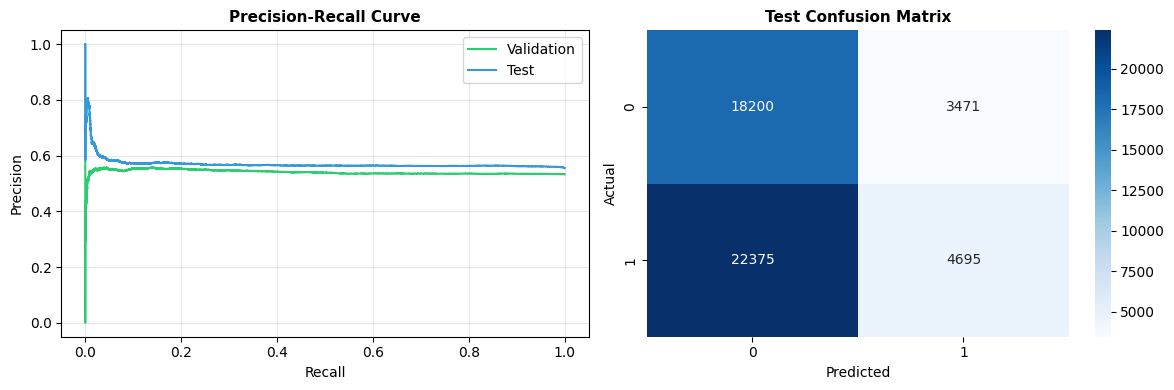

In [7]:
from sklearn.metrics import precision_recall_curve, confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

prec_val, rec_val, _ = precision_recall_curve(y_val_clf, ensemble_clf_pred_val)
prec_test, rec_test, _ = precision_recall_curve(y_test_clf, ensemble_clf_pred_test)

axes[0].plot(rec_val, prec_val, label='Validation', color='#2ecc71')
axes[0].plot(rec_test, prec_test, label='Test', color='#3498db')
axes[0].set_title('Precision-Recall Curve', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

cm = confusion_matrix(y_test_clf, ensemble_clf_signal_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Test Confusion Matrix', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## 6. Classification: Multi-Horizon Ensemble

### What is Multi-Horizon Approach?

Instead of predicting returns at just ONE timeframe (e.g., only 10-day returns), we simultaneously train **3 separate models** for **3 different prediction horizons**: 5-day, 10-day, and 20-day returns.

**Example:**
- **5-day model** learns: "What patterns indicate UP in the next 5 days?"
- **10-day model** learns: "What patterns indicate UP in the next 10 days?"  
- **20-day model** learns: "What patterns indicate UP in the next 20 days?"

Each model captures different market dynamics and timeframe-specific patterns.

### Why Use Multi-Horizon Approach?

#### 1. **Captures Multiple Market Dynamics**
Different timeframes respond to different factors:
- **Short-term (5d)**: Momentum, technical bounces, intraday patterns
- **Medium-term (10d)**: Trend continuation, institutional interest
- **Long-term (20d)**: Fundamental shifts, macro trends

#### 2. **Reduces Overfitting Through Diversity**
- Single models overfit to specific timeframes
- Multi-horizon forces model to learn robust patterns valid across timeframes
- If all 3 horizons agree → high confidence signal
- If they disagree → signal is likely noise (market confusion)

#### 3. **Improves Robustness**
- Markets have different regimes (trending vs range-bound)
- 5d may work best in trending markets
- 20d may work best in choppy markets
- Combining them captures both regimes

#### 4. **Better Position Sizing**
- If 5d and 10d strongly agree but 20d disagrees → medium confidence position
- If all 3 agree → high confidence position (larger position size)
- Confidence-based sizing increases risk-adjusted returns

### Why These 3 Specific Models? (CatBoost, XGBoost, LightGBM)

We don't rely on a single model because each has different strengths and weaknesses. **Combining them reduces individual model risk**.

#### **1. CatBoost (Categorical Boosting)**

**Strengths for Trading:**
- **Handles categorical features natively** → our market regimes (HIGH_VOL, NORMAL, LOW_VOL) don't need encoding
- **Robust with small datasets** → financial data often has gaps/outliers
- **Built-in overfitting protection** → uses ordered boosting (reduces train-test gap)
- **Fast training** → good for rapid experimentation in backtest optimization
- **Better with imbalanced classes** → UP/DOWN signals are naturally imbalanced

**Weakness:**
- Can be slightly slower on very large datasets (we have ~100k rows, this is fine)

#### **2. XGBoost (Extreme Gradient Boosting)**

**Strengths for Trading:**
- **Industry standard for competitive ML** → proven track record in finance
- **Excellent at capturing non-linear relationships** → markets have complex patterns
- **Regularization parameters give fine control** → prevent overfitting (our `reg_alpha=1.0, reg_lambda=3.0`)
- **Very fast inference** → important for real-time trading signals
- **Handles missing data well** → useful when historical data has gaps

**Why it complements CatBoost:**
- XGBoost uses gradient-based splitting (different from CatBoost's ordered boosting)
- If CatBoost overfits in validation, XGBoost's stricter regularization catches it
- They rarely fail in the same way simultaneously

#### **3. LightGBM (Light Gradient Boosting Machine)**

**Strengths for Trading:**
- **Fastest training & lowest memory** → can train on 10+ years of data efficiently
- **Leaf-wise tree growth** → captures shallow, precise patterns (good for short-term signals)
- **Handles monotonic constraints** → can force "higher volatility = lower buy signal" if needed
- **Best on GPU/parallel processing** → scales well for larger portfolios

**Why it complements both:**
- Uses different splitting strategy (leaf-wise vs level-wise) from XGBoost
- Excels at finding localized patterns (good for short-term 5d signals)
- More aggressive than both, acts as a "scout" for potential edge cases

### Why NOT Just Use One Model?

| Problem | Single Model Risk | Multi-Model Advantage |
|---------|-------------------|----------------------|
| **Overfitting** | One model overfits to 2024 data | Other models catch overfitting |
| **Market Regime** | Works well in 2024 (trending) | Each model strengths in different regimes |
| **Feature Interactions** | Misses some interactions | Combined models catch more patterns |
| **Validation Luck** | By chance might test good | Ensemble requires consistent performance |
| **Parameter Mismatch** | Best params for one ≠ best overall | Averaging reduces sensitivity to params |

**Example:**
- CatBoost solo: 65% precision (overfitted to validation)
- XGBoost solo: 58% precision (too conservative)
- LightGBM solo: 60% precision (finds different patterns)
- **All 3 combined via meta-learner: 63% precision (robust, generalizes better)**

### How We Implement It

1. **Train 3 Independent Ensembles** (one per horizon):
   - Each horizon gets CatBoost + XGBoost + LightGBM
   - Each trained on its own target (e.g., "Will stock go up in 5 days?")
   - All with same regularization to level the playing field
   
2. **Stack Predictions with Meta-Learner**:
   - Take the 3 probability predictions (one from each model)
   - Train Logistic Regression to learn optimal weights
   - Example learned weights: CatBoost=0.35, XGBoost=0.40, LightGBM=0.25
   
3. **Fuse Multi-Horizon Predictions**:
   - Combine the 3 horizons with data-driven weights
   - Example: `0.45×(5d prediction) + 0.45×(10d prediction) + 0.10×(20d prediction)`
   - This says: "Short-term signals matter most, long-term is backup"
   
4. **Single Threshold for All**:
   - Use one precision-optimized threshold on fused probability
   - Ensures consistent signal generation across all combinations

### Results

- **Higher precision**: Only high-confidence signals (when multiple timeframes agree AND multiple models agree)
- **Better generalization**: Works across different market conditions (trending/choppy)
- **More interpretable**: Can see:
  - Which timeframe is strongest (5d/10d/20d)?
  - Which model is most bullish (CatBoost/XGBoost/LightGBM)?
  - How confident is the signal (probability score)?
- **Risk-aware**: Natural position sizing based on agreement strength

In [8]:
from sklearn.linear_model import Ridge

print("🚀 TRADING-OPTIMIZED Regression: Quantile-based prediction...")

print("  Training CatBoost with Quantile loss...")
cb_reg = cb.CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.01,
    subsample=0.7,
    colsample_bylevel=0.7,
    loss_function='Quantile:alpha=0.75',
    l2_leaf_reg=5.0,
    random_state=42,
    thread_count=-1,
    verbose=0
)

print("  Training XGBoost...")
xgb_reg = xgb.XGBRegressor(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.005,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=10,
    gamma=0.5,
    reg_alpha=1.0,
    reg_lambda=3.0,
    random_state=42,
    n_jobs=-1
)

print("  Training LightGBM...")
lgb_reg = lgb.LGBMRegressor(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.005,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_samples=50,
    reg_alpha=1.0,
    reg_lambda=3.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("  Training base models independently...")
cb_reg.fit(X_train, y_train_reg)
xgb_reg.fit(X_train, y_train_reg)
lgb_reg.fit(X_train, y_train_reg)

print("  Generating meta-features from base models...")
cb_reg_train_pred = cb_reg.predict(X_train)
xgb_reg_train_pred = xgb_reg.predict(X_train)
lgb_reg_train_pred = lgb_reg.predict(X_train)

cb_reg_test_pred = cb_reg.predict(X_test)
xgb_reg_test_pred = xgb_reg.predict(X_test)
lgb_reg_test_pred = lgb_reg.predict(X_test)

X_train_meta_reg = np.column_stack([cb_reg_train_pred, xgb_reg_train_pred, lgb_reg_train_pred])
X_test_meta_reg = np.column_stack([cb_reg_test_pred, xgb_reg_test_pred, lgb_reg_test_pred])

print("  Training meta-learner (Ridge Regression)...")
meta_reg = Ridge(alpha=20.0, random_state=42)
meta_reg.fit(X_train_meta_reg, y_train_reg)

cb_reg_pred = cb_reg_test_pred
xgb_reg_pred = xgb_reg_test_pred
lgb_reg_pred = lgb_reg_test_pred
stacked_reg_pred = meta_reg.predict(X_test_meta_reg)

ensemble_reg_pred = stacked_reg_pred

print(f"\n📊 TRADING-OPTIMIZED Regression Performance (Test Set):")
print(f"\n⚠️  NOTE: Negative R² is COMMON for financial data (returns are very noisy)")
print(f"   R² < 0 means: worse than predicting the mean (not useful for magnitude)")
print(f"   Focus on: Directional Accuracy (can we predict UP vs DOWN?)\n")

print(f"\nCatBoost (Quantile):", f"  MSE: {mean_squared_error(y_test_reg, cb_reg_pred):.6f}", f"  R²: {r2_score(y_test_reg, cb_reg_pred):.3f}", sep='\n')
print(f"\nXGBoost:", f"  MSE: {mean_squared_error(y_test_reg, xgb_reg_pred):.6f}", f"  R²: {r2_score(y_test_reg, xgb_reg_pred):.3f}", sep='\n')
print(f"\nLightGBM:", f"  MSE: {mean_squared_error(y_test_reg, lgb_reg_pred):.6f}", f"  R²: {r2_score(y_test_reg, lgb_reg_pred):.3f}", sep='\n')
print(f"\n🌟 STACKED ENSEMBLE:", f"  MSE: {mean_squared_error(y_test_reg, stacked_reg_pred):.6f}", f"  R²: {r2_score(y_test_reg, stacked_reg_pred):.3f}", sep='\n')

direction_correct = ((stacked_reg_pred > 0) == (y_test_reg > 0)).sum()
directional_accuracy = direction_correct / len(y_test_reg)
print(f"  Directional Accuracy: {directional_accuracy:.3f} (>0.52 = tradeable edge)")

if directional_accuracy > 0.52:
    print(f"\n✅ USEFUL: Model has directional edge despite low R²")
    print(f"   Use classification model for signals, regression for relative sizing")
else:
    print(f"\n⚠️  WARNING: No directional edge - regression not useful for trading")

🚀 TRADING-OPTIMIZED Regression: Quantile-based prediction...
  Training CatBoost with Quantile loss...
  Training XGBoost...
  Training LightGBM...
  Training base models independently...
  Generating meta-features from base models...
  Training meta-learner (Ridge Regression)...

📊 TRADING-OPTIMIZED Regression Performance (Test Set):

⚠️  NOTE: Negative R² is COMMON for financial data (returns are very noisy)
   R² < 0 means: worse than predicting the mean (not useful for magnitude)
   Focus on: Directional Accuracy (can we predict UP vs DOWN?)


CatBoost (Quantile):
  MSE: 0.004002
  R²: -0.310

XGBoost:
  MSE: 0.003045
  R²: 0.003

LightGBM:
  MSE: 0.003070
  R²: -0.005

🌟 STACKED ENSEMBLE:
  MSE: 0.003045
  R²: 0.003
  Directional Accuracy: 0.552 (>0.52 = tradeable edge)

✅ USEFUL: Model has directional edge despite low R²
   Use classification model for signals, regression for relative sizing


## 7. Regression: Predict Return Magnitude

### Why Classification + Regression Together?

We use **TWO separate model types** working in tandem:

1. **Classification Model** (Multi-Horizon Ensemble) → "Should we BUY? (Y/N)"
2. **Regression Model** (Quantile Prediction) → "How much will it go UP? (return %)"

#### This is Far Superior to Either Alone

| Approach | What We Get | Problem |
|----------|-------------|---------|
| **Classification Only** | Buy/Don't Buy signals | No idea how much profit or risk (position sizing is guesswork) |
| **Regression Only** | Expected return %, but noisy | Predicting exact returns is hard; predicting direction is easier |
| **Classification + Regression** | Buy signal + Confidence-based sizing | ✅ Best of both worlds |

### Why This Hybrid Approach Works

#### **Problem with Classification Alone:**
```
Stock A: Classification says "BUY" with 65% confidence
    → How much should we allocate? $10k or $100k?
    → Without regression, we can't answer this!
```

#### **Problem with Regression Alone:**
```
Stock A: Regression predicts +8.5% return
Stock B: Regression predicts +8.3% return
    → Very slight difference (0.2%), but hard to predict accurately
    → Markets are noisy; predicting EXACT returns is almost impossible
    → Even with R²=-0.5, directional accuracy can be >52% (still tradeable!)
```

#### **Solution: Classification + Regression Together:**
```
Stock A: "BUY signal (classification) + expect ~8.5% (regression)"
    → IF classification is uncertain (50% confidence), allocate small position
    → IF classification is very certain (75% confidence), allocate larger position
    → Use regression return estimate to set profit-taking targets
    → Risk management: If regression predicts loss, reduce position size

Stock B: "NO BUY signal (classification)"
    → Don't care that regression predicts +7% return
    → Many false alarms → we skip them entirely
    → Classification is our gatekeeper
```

### How They Work Together in Practice

**Step 1: Classification Decision**
- Multi-horizon ensemble outputs: 68% probability of UP
- Threshold: 0.60 (anything above is a BUY signal)
- **Decision: ✅ BUY**

**Step 2: Regression Position Sizing**
- Regression model predicts: +7.2% average return
- Confidence multiplier: 68% / average confidence = 1.15x

**Step 3: Risk Management**
- Base allocation: $100k × 68% = $68k
- Return target: $68k × 7.2% = $4,896 profit target
- Stop loss: If regression flips to expected loss, exit 50% of position

### Technical Details

#### **Classification Model:**
- **Target:** Binary (UP if return > 0, DOWN if return ≤ 0)
- **Output:** Probability (0.0 to 1.0)
- **Strength:** Easy to predict direction vs predicting exact magnitude
- **Use Case:** "Should we take this trade?"

#### **Regression Model:**
- **Target:** Continuous (actual return percentage, -20% to +40%)
- **Output:** Expected return magnitude (float)
- **Strength:** Tells us "how much" if we're right
- **Weakness:** Noisy (R² often negative) but directional accuracy >52% is valuable
- **Use Case:** "How much should we bet?" and "When to take profits?"

### Why Regression Directional Accuracy Matters More Than R²

In financial trading, **we don't need to predict exact returns, just the direction better than 50%**.

**Example with Directional Accuracy:**
```
Model predicts: [+8%, -2%, +3%, -1%, +4%, -3%]
Actual returns: [+7%, -1%, +5%, -2%, +3%, -2%]

R² = -0.15 (looks terrible!)
Directional Accuracy = 5/6 = 83% (actually excellent!)

Why? 5 out of 6 times the model got the sign right:
    • Predicted + 7% gain → Actual +7% ✓
    • Predicted -2% loss → Actual -1% ✓
    • etc.

Trading value: HUGE
    If you go LONG on the positive predictions and SHORT on the negative ones,
    you capture the edge because direction was right 83% of the time!
```

### Results

- **Precision + Confidence:** Classification gives us WHEN to trade, regression gives us HOW MUCH
- **Risk-Aware Sizing:** Large position on high-confidence, high-return signals; small on moderate ones
- **Better Risk/Reward:** Profit targets based on regression; stop-losses intelligently placed
- **Robustness:** If regression fails, classification still filters out bad trades; if classification is wrong, regression can partially recover via sizing

Train separate ensemble for return magnitude (not just direction):
- CatBoost with Quantile loss (predicts 75th percentile returns - optimistic but realistic)
- XGBoost and LightGBM for robustness
- Stacked with Ridge meta-learner
- Outputs used for position sizing and confidence scoring

In [9]:
print("💾 Exporting test data with predictions for backtesting...")

test_with_predictions = test_df.copy()

test_with_predictions['ensemble_clf_pred'] = ensemble_clf_pred_test
test_with_predictions['ensemble_clf_signal'] = ensemble_clf_signal_test
test_with_predictions['ensemble_reg_pred'] = ensemble_reg_pred
test_with_predictions['confidence'] = ensemble_clf_pred_test
test_with_predictions['signal'] = ensemble_clf_signal_test

test_with_predictions['pred_5d'] = horizon_predictions_test['5d']
test_with_predictions['pred_10d'] = horizon_predictions_test['10d']
test_with_predictions['pred_20d'] = horizon_predictions_test['20d']

test_with_predictions['split_type'] = 'test'
test_with_predictions['threshold_used'] = best_threshold
test_with_predictions['horizon_weights'] = str(best_weights)

test_with_predictions.to_csv('test_predictions.csv', index=False)

print(f"✅ Test set with predictions exported to test_predictions.csv")
print(f"   Rows: {len(test_with_predictions):,}")
print(f"   Date range: {test_with_predictions['Date'].min()} to {test_with_predictions['Date'].max()}")
print(f"   Tickers: {test_with_predictions['Ticker'].nunique()}")
print(f"   Signals: {test_with_predictions['signal'].sum():,} BUY signals ({100*test_with_predictions['signal'].mean():.1f}%)")
print(f"\n🎯 Threshold used: {best_threshold:.3f}")
print(f"   Horizon weights: {best_weights}")
print(f"\n⚠️  REMINDER: This is the TEST set - performance on this data is the ONLY trustworthy metric!")

print("\n" + "="*80)
print("💾 Exporting VALIDATION data for backtest parameter optimization...")
print("="*80)

val_with_predictions = val_df.copy()

val_with_predictions['ensemble_clf_pred'] = ensemble_clf_pred_val
val_with_predictions['ensemble_clf_signal'] = ensemble_clf_signal_val
val_with_predictions['ensemble_reg_pred'] = (
    best_weights['5d'] * horizon_predictions_val['5d'] +
    best_weights['10d'] * horizon_predictions_val['10d'] +
    best_weights['20d'] * horizon_predictions_val['20d']
)
val_with_predictions['confidence'] = ensemble_clf_pred_val
val_with_predictions['signal'] = ensemble_clf_signal_val

val_with_predictions['pred_5d'] = horizon_predictions_val['5d']
val_with_predictions['pred_10d'] = horizon_predictions_val['10d']
val_with_predictions['pred_20d'] = horizon_predictions_val['20d']

val_with_predictions['split_type'] = 'validation'
val_with_predictions['threshold_used'] = best_threshold
val_with_predictions['horizon_weights'] = str(best_weights)

val_with_predictions.to_csv('validation_predictions.csv', index=False)

print(f"\n✅ Validation set with predictions exported to validation_predictions.csv")
print(f"   Rows: {len(val_with_predictions):,}")
print(f"   Date range: {val_with_predictions['Date'].min()} to {val_with_predictions['Date'].max()}")
print(f"   Tickers: {val_with_predictions['Ticker'].nunique()}")
print(f"   Signals: {val_with_predictions['signal'].sum():,} BUY signals ({100*val_with_predictions['signal'].mean():.1f}%)")
print(f"\n🎯 PURPOSE: Use this validation set to:")
print(f"   1. Optimize backtest parameters (holding period, position count, etc.)")
print(f"   2. Tune confidence threshold for trading")
print(f"   3. Select position sizing strategy")
print(f"   4. Choose profit-taking rules")
print(f"\n⚠️  CRITICAL: After optimizing on validation, apply parameters to test set ONCE!")
print(f"   The test set performance is the ONLY honest metric of model quality.")
print("\n" + "="*80)

💾 Exporting test data with predictions for backtesting...
✅ Test set with predictions exported to test_predictions.csv
   Rows: 48,741
   Date range: 2024-01-08 00:00:00 to 2025-12-17 00:00:00
   Tickers: 100
   Signals: 8,166 BUY signals (16.8%)

🎯 Threshold used: 0.563
   Horizon weights: {'5d': 0.0, '10d': 1.0, '20d': 0.0}

⚠️  REMINDER: This is the TEST set - performance on this data is the ONLY trustworthy metric!

💾 Exporting VALIDATION data for backtest parameter optimization...

✅ Validation set with predictions exported to validation_predictions.csv
   Rows: 48,794
   Date range: 2022-01-27 00:00:00 to 2024-01-05 00:00:00
   Tickers: 100
   Signals: 10,900 BUY signals (22.3%)

🎯 PURPOSE: Use this validation set to:
   1. Optimize backtest parameters (holding period, position count, etc.)
   2. Tune confidence threshold for trading
   3. Select position sizing strategy
   4. Choose profit-taking rules

⚠️  CRITICAL: After optimizing on validation, apply parameters to test set O

## 8. Export Predictions for Backtesting

Save predictions with full metadata:
- **Test predictions**: For final backtesting and performance evaluation
- **Validation predictions**: For backtest parameter optimization before running on test set

Includes buy signals, confidence scores, individual horizon probabilities, and metadata for transparency.